In [1]:
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
import datetime
#from us import states
from scipy.stats import linregress
import scipy.stats as st
from matplotlib import pyplot as plt
from glob import glob
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

In [28]:
### BEGIN Airport Data retrieval & clean ###

In [29]:
#Airport Data 2016
airport_data_2016 = '../project_data/airline_data/TFMSC_Report_2016.csv'
df = pd.read_csv(airport_data_2016)
new_df = df.dropna()
#new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2016_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2016_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2016,ATL - Atlanta,US to Foreign,9,"2,975"
1,1/1/2016,ATL - Atlanta,US to Foreign,1,550
2,1/1/2016,ATL - Atlanta,US to Foreign,1,0
3,1/1/2016,ATL - Atlanta,US to Foreign,7,"1,610"
4,1/1/2016,ATL - Atlanta,US to Foreign,5,"1,225"


In [30]:
#Airport Data 2017
airport_data_2017 = '../project_data/airline_data/TFMSC_Report_2017.csv'
df = pd.read_csv(airport_data_2017)
new_df = df.dropna()
#new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2017_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
#cleaned_2017_df.head()

In [31]:
#Airport Data 2018
airport_data_2018 = '../project_data/airline_data/TFMSC_Report_2018.csv'
df = pd.read_csv(airport_data_2018)
new_df = df.dropna()
#new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2018_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
#cleaned_2018_df.head()

In [32]:
#Airport Data 2019
airport_data_2019 = '../project_data/airline_data/TFMSC_Report_2019.csv'
df = pd.read_csv(airport_data_2019)
new_df = df.dropna()
#new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2019_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
#cleaned_2019_df.head()

In [33]:
#Airport Data 2020
airport_data_2020 = '../project_data/airline_data/TFMSC_Report_2020.csv'
df = pd.read_csv(airport_data_2020)
new_df = df.dropna()
#new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2020_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
#cleaned_2020_df.head()

In [34]:
#Combined Data for Airports
combined_airport = pd.concat([cleaned_2016_df,cleaned_2017_df,cleaned_2018_df,cleaned_2019_df,cleaned_2020_df])
#combined_airport

In [35]:
###BEGIN JAYDEN'S work on feb17 vs feb18 flight data###

In [36]:
#FLU AIRPORT DATA#
combined_airport['Date'] = pd.to_datetime(combined_airport['Date'])
#combined_airport

In [88]:
#February 2017 Flight Data
start_2017 = '02-01-2017'
end_2017 = '02-28-2017'

#Mask date column to get range of data
mask = (combined_airport['Date'] > start_2017) & (combined_airport['Date'] <= end_2017)

#Create dataframe for February 2017 flights
february_airport_2017 = pd.DataFrame
february_airport_2017 = combined_airport.loc[mask]

# Total Departures for Atlanta
atlanta_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'ATL - Atlanta']
total_atl_flights_2017 = atlanta_flights['Departures'].sum()
#print(total_atl_flights_2017)

#Total Departures for Dallas
dallas_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2017 = dallas_flights['Departures'].sum()
#print(total_dallas_flights_2017)

#Total Departures for New York
newyork_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'JFK - New York']
total_newyork_flights_2017 = newyork_flights['Departures'].sum()
#print(total_newyork_flights_2017)

#Total Departures for Los Angeles
losangeles_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2017 = losangeles_flights['Departures'].sum()
#print(total_losangeles_flights_2017)

#Total Departures for Chicago
chicago_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'ORD - Chicago']
total_chicago_flights_2017 = chicago_flights['Departures'].sum()
#print(total_chicago_flights_2017)

In [89]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights_2017,total_dallas_flights_2017,total_newyork_flights_2017,total_losangeles_flights_2017,total_chicago_flights_2017]
total_departures_2017 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
#total_departures_2017

In [90]:
#March 2018 Flight Data
combined_airport
start_2018 = '02-01-2018'
end_2018 = '02-28-2018'
mask = (combined_airport['Date'] > start_2018) & (combined_airport['Date'] <= end_2018)
february_airport_2018 = pd.DataFrame
february_airport_2018 = combined_airport.loc[mask]
#february_airport_2018.groupby(['Airport'])
#february_airport_2018.head()

# Total Departures for Atlanta
atlanta_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'ATL - Atlanta']
total_atl_flights_2018 = atlanta_flights['Departures'].sum()
#print(total_atl_flights_2018)

#Total Departures for Dallas
dallas_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2018 = dallas_flights['Departures'].sum()
#print(total_dallas_flights_2018)

#Total Departures for New York
newyork_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'JFK - New York']
total_newyork_flights_2018 = newyork_flights['Departures'].sum()
#print(total_newyork_flights_2018)

#Total Departures for Los Angeles
losangeles_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2018 = losangeles_flights['Departures'].sum()
#print(total_losangeles_flights_2018)

#Total Departures for Chicago
chicago_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'ORD - Chicago']
total_chicago_flights_2018 = chicago_flights['Departures'].sum()
#print(total_chicago_flights_2018)

In [91]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights_2018,total_dallas_flights_2018,total_newyork_flights_2018,total_losangeles_flights_2018,total_chicago_flights_2018]
total_departures_2018 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
#total_departures_2018

<IPython.core.display.Javascript object>


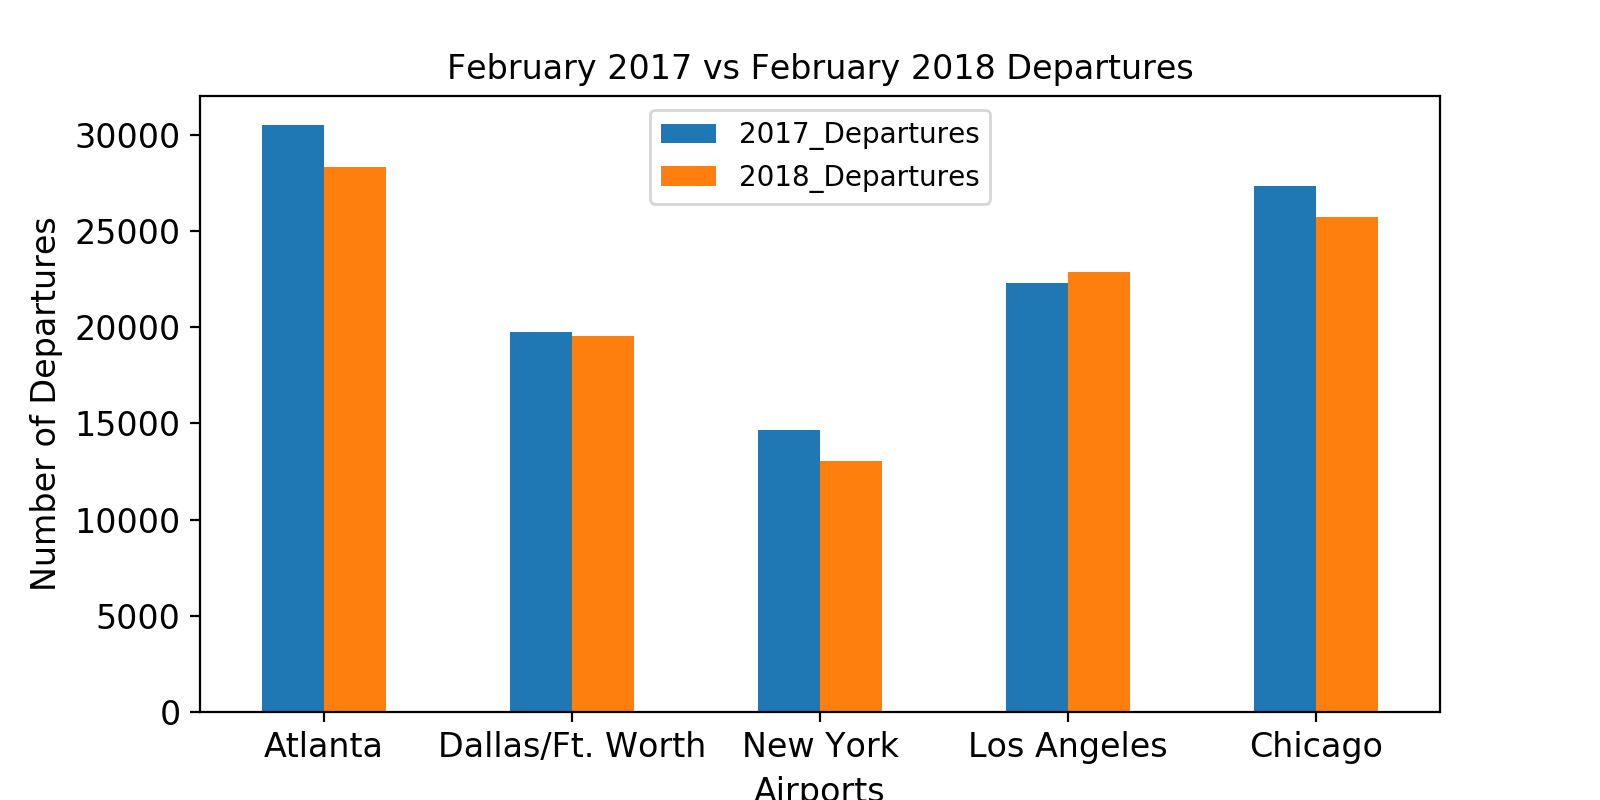

In [92]:
#Merge 2017 and 2018 to create comparison bar graphs
merged_february_departures = pd.merge(total_departures_2017,total_departures_2018, how = 'inner', on='Airport')
#merged_february_departures

#rename departure columns
merged_february_departures.rename(columns={'Departures_x': '2017_Departures','Departures_y':'2018_Departures'}, inplace = True)
indexed_february_departures = merged_february_departures.set_index('Airport')
indexed_february_departures
final_february_departure = indexed_february_departures[['2017_Departures','2018_Departures']].plot(kind= 'bar',title = 'February 2017 vs February 2018 Departures', figsize = (8,4),legend = True, fontsize =12, rot=0)
final_february_departure.set_xlabel('Airports', fontsize =12)
final_february_departure.set_ylabel('Number of Departures', fontsize=12)
#Save Bar graph to file
plt.savefig("../images/februarydepartures.png")
#Collapse

In [93]:
###BEGIN JAYDEN'S work on mar19 vs mar20 flight data###

In [94]:
#Changed data type to datetime
combined_airport['Date'] = pd.to_datetime(combined_airport['Date'])
combined_airport

#March 2019 Flight Data
start_2019 = '03-01-2019'
end_2019 = '03-31-2019'

#Mask date column to get range of data
mask = (combined_airport['Date'] > start_2019) & (combined_airport['Date'] <= end_2019)

#Create dataframe for March 2019 flights
march_airport_2019 = pd.DataFrame
march_airport_2019 = combined_airport.loc[mask]

# Total Departures for Atlanta
atlanta_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ATL - Atlanta']
total_atl_flights = atlanta_flights['Departures'].sum()
#print(total_atl_flights)

#Total Departures for Dallas
dallas_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights = dallas_flights['Departures'].sum()
#print(total_dallas_flights)

#Total Departures for New York
newyork_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'JFK - New York']
total_newyork_flights = newyork_flights['Departures'].sum()
#print(total_newyork_flights)

#Total Departures for Los Angeles
losangeles_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights = losangeles_flights['Departures'].sum()
#print(total_losangeles_flights)

#Total Departures for Chicago
chicago_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ORD - Chicago']
total_chicago_flights = chicago_flights['Departures'].sum()
#print(total_chicago_flights)

In [95]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights,total_dallas_flights,total_newyork_flights,total_losangeles_flights,total_chicago_flights]

total_departures_2019 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
#total_departures_2019


In [96]:
#March 2020 Flight Data
combined_airport

start_2020 = '03-01-2020'
end_2020 = '03-31-2020'

mask = (combined_airport['Date'] > start_2020) & (combined_airport['Date'] <= end_2020)

march_airport_2020 = pd.DataFrame
march_airport_2020 = combined_airport.loc[mask]

march_airport_2020.groupby(['Airport'])
#march_airport_2020.head()

In [97]:
# Total Departures for Atlanta
atlanta_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ATL - Atlanta']
total_atl_flights_2020 = atlanta_flights_2020['Departures'].sum()
#print(total_atl_flights_2020)

#Total Departures for Dallas
dallas_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2020 = dallas_flights_2020['Departures'].sum()
#print(total_dallas_flights_2020)

#Total Departures for New York
newyork_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'JFK - New York']
total_newyork_flights_2020 = newyork_flights_2020['Departures'].sum()
#print(total_newyork_flights_2020)

#Total Departures for Los Angeles
losangeles_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2020 = losangeles_flights_2020['Departures'].sum()
#print(total_losangeles_flights_2020)

#Total Departures for Chicago
chicago_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ORD - Chicago']
total_chicago_flights_2020 = chicago_flights_2020['Departures'].sum()
#print(total_chicago_flights_2020)

In [98]:
#Dataframe for total Departures for each Airport 
airports_2020 = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures_2020 = [total_atl_flights_2020,total_dallas_flights_2020,total_newyork_flights_2020,total_losangeles_flights_2020,total_chicago_flights_2020]

total_departures_2020 = pd.DataFrame(list(zip(airports_2020,departures_2020)),columns= ['Airport','Departures'])
#total_departures_2020


In [99]:
#Merge 2019 and 2020 to create comparison bar graphs
merged_march_departures = pd.merge(total_departures_2019,total_departures_2020, how = 'inner', on='Airport')
#merged_march_departures

#rename departure columns
merged_march_departures.rename(columns={'Departures_x': '2019_Departures','Departures_y':'2020_Departures'}, inplace = True)
indexed_march_departures = merged_march_departures.set_index('Airport')

#indexed_march_departures

<IPython.core.display.Javascript object>


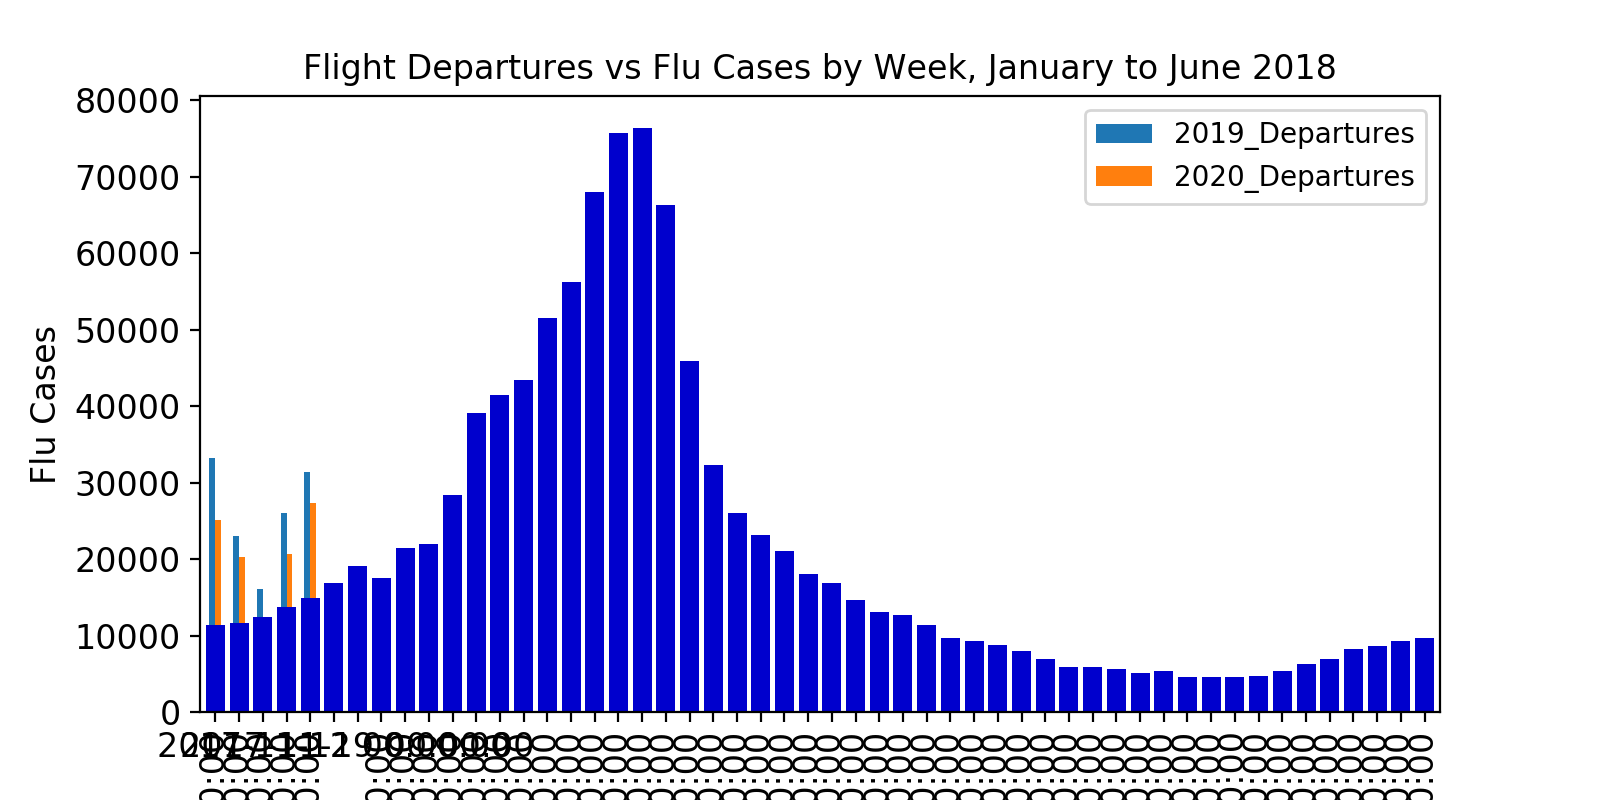

In [100]:
final_march_departure = indexed_march_departures[['2019_Departures','2020_Departures']].plot(kind= 'bar',title = 'March 2019 vs March 2020 Departures', figsize = (8,4),legend = True, fontsize =12, rot=0)
final_march_departure.set_xlabel('Airports', fontsize =12)
final_march_departure.set_ylabel('Number of Departures', fontsize=12)

#Save Bar grpah to file
plt.savefig("../images/marchdepartures.png")

In [101]:
###Begin Max&Danny&Dave's work on Departure Seats calculation for all 5 years

In [103]:
#display combined_airport df
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2016-01-01,ATL - Atlanta,US to Foreign,9,2975,1,2016
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550,1,2016
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0,1,2016
3,2016-01-01,ATL - Atlanta,US to Foreign,7,1610,1,2016
4,2016-01-01,ATL - Atlanta,US to Foreign,5,1225,1,2016
...,...,...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0,7,2020
37360,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37361,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37362,2020-07-01,ORD - Chicago,Domestic,0,0,7,2020


In [52]:
#Change Date to datetime
combined_airport['month'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.month
combined_airport['year'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.year
#combined_airport

In [139]:
#Change Data Type for Departure Seats in combined_airport to Integer
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(str) 
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].str.replace(',', '')
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(int)
combined_airport.dtypes

Date               datetime64[ns]
Airport                    object
Flight Type                object
Departures                  int64
Departure Seats             int64
month                       int64
year                        int64
dtype: object

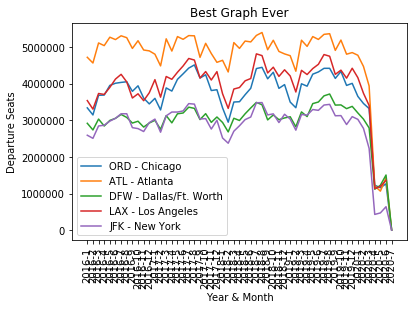

In [143]:
import matplotlib.pyplot as plt
%matplotlib inline
# Used for combining year-month
date_group = []
# Self explains
airport_names = ["ORD - Chicago",
                 "ATL - Atlanta",
                 "DFW - Dallas/Ft. Worth",
                 "LAX - Los Angeles",
                 "JFK - New York"]
# The group by used to sum departures
gp = combined_airport.groupby(['Airport','year','month'])
airport_all = gp.sum()
#print(airport_all)
# concatenating the multiindex year and month column into one
for i in airport_all.index:
    date_group.append(str(i[1]) + "-" + str(i[2]))
# Creating the x axis values used to display the time series
airport_all["date_group"] = date_group
# Drop the index
airport_all.droplevel(['year', 'month'])
# Conjutes the canvas used to draw the graphs
fig, ax = plt.subplots()
# Iterate over airports and draws a time series for each
for airport in airport_names:
    df = airport_all.loc[airport,["Departure Seats", "date_group"]]
    line, = ax.plot(df["date_group"], df["Departure Seats"], label = airport)
plt.xticks(rotation=90)
plt.xlabel("Year & Month")
plt.ylabel("Departure Seats")
ax.legend()
plt.title("Best Graph Ever")
plt.rcParams['figure.figsize'] = (20,4)
plt.savefig("../images/departseats_all.png")
plt.show()

In [56]:
### BEGIN DAVE's code below for 2017-18 flu ###
# import and clean data from CDC FluView website csv download

In [106]:
# define data file
flu_state = "../project_data/flu_data/State_ILINet.csv"

In [107]:
# read data file
raw_state_flu_2017 = pd.read_csv(flu_state)

In [159]:
# raw_state_flu_2017.head(15)

In [109]:
# create datetime column from year and week 
raw_state_flu_2017['formatted_date'] = raw_state_flu_2017.YEAR * 1000 + raw_state_flu_2017.WEEK * 10
raw_state_flu_2017['date'] = pd.to_datetime(raw_state_flu_2017['formatted_date'], format='%Y%W%w')
#raw_state_flu_2017.head()

In [110]:
# collect a list of all columns within the DataFrame
raw_state_flu_2017.columns

Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', '% WEIGHTED ILI',
       '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS',
       'TOTAL PATIENTS', 'formatted_date', 'date'],
      dtype='object')

In [111]:
# extract required columns to new DataFrame
temp_state_flu_2017 = raw_state_flu_2017[['REGION', 'YEAR', 'WEEK', 'date', 'ILITOTAL']]
#temp_state_flu_2017.head()

In [112]:
# drop rows with "X" in ILITOTAL column
temp_state_flu_2017 = temp_state_flu_2017[temp_state_flu_2017.ILITOTAL != 'X']
#temp_state_flu_2017.head(15)

In [160]:
#check data types
# temp_state_flu_2017.dtypes

In [161]:
# identify incomplete rows
# temp_state_flu_2017.count()

In [162]:
# use pd.to_numeric() method to convert the datatype of the ILITOTAL column
temp_state_flu_2017['ILITOTAL'] = pd.to_numeric(temp_state_flu_2017['ILITOTAL'])
temp_state_flu_2017['ILITOTAL'].dtype

dtype('int64')

In [67]:
# rename the columns     
clean_state_flu_2017 = temp_state_flu_2017.rename(columns={"REGION":"State",
                                                           "YEAR":"Year",
                                                           "WEEK":"Week",
                                                           "date":"Week Ending Date",
                                                           "ILITOTAL":"ILI Cases"})
#clean_state_flu_2017.head()

In [68]:
# determine the total number of ILI Cases
total_cases = clean_state_flu_2017["ILI Cases"].sum()
#total_cases

In [115]:
# determine the total of all ILI Cases by week
ILI_by_week = clean_state_flu_2017.groupby(['Week Ending Date']).sum()['ILI Cases']
#ILI_by_week

In [117]:
# count how many ILI cases have occured within each state
ILI_by_state = clean_state_flu_2017.groupby('State').sum()['ILI Cases']
#ILI_by_state.head()

In [119]:
# determine the total of all ILI Cases by week per state
ILI_by_state_by_week = clean_state_flu_2017.groupby(['State', 'Week Ending Date']).sum()['ILI Cases']
#ILI_by_state_by_week.head(15)

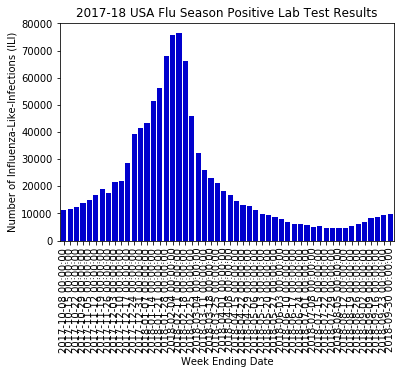

In [163]:
%matplotlib inline
# create a bar chart from the series
ILI_by_week.plot.bar(x='Week Ending Date', y=ILI_by_week, color='mediumblue', align="center", width=0.8)

# give the chart some labels and a title
plt.title("2017-18 USA Flu Season Positive Lab Test Results")
plt.xlabel("Week Ending Date")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_week.png")
plt.show()

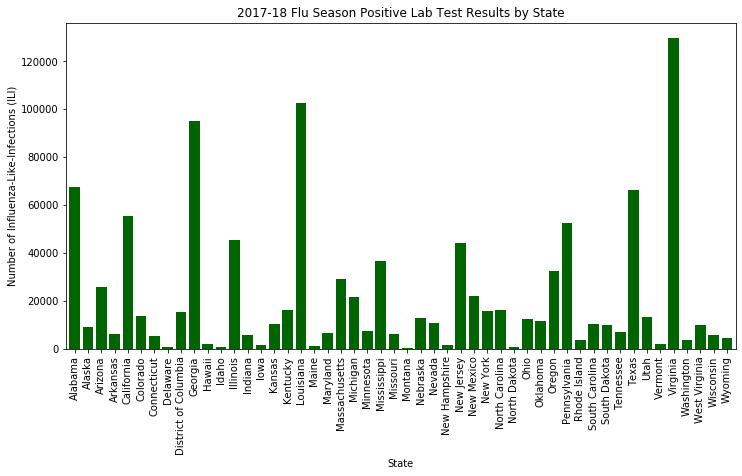

In [134]:
%matplotlib inline
# create a bar chart from the series
ILI_by_state.plot.bar(x='Week Ending Date', y=ILI_by_state, color='darkgreen', align="center", width=0.8)

# give the chart some labels and a title
plt.title("2017-18 Flu Season Positive Lab Test Results by State")
plt.xlabel("State")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_state.png")
plt.show()

In [77]:
###Part Three###

In [122]:
###BEGIN DANNY & DAVE & MAX's Work on CORRELATION GRAPHS

#display df
# combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2016-01-01,ATL - Atlanta,US to Foreign,9,2975,1,2016
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550,1,2016
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0,1,2016
3,2016-01-01,ATL - Atlanta,US to Foreign,7,1610,1,2016
4,2016-01-01,ATL - Atlanta,US to Foreign,5,1225,1,2016
...,...,...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0,7,2020
37360,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37361,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37362,2020-07-01,ORD - Chicago,Domestic,0,0,7,2020


In [123]:
#build df with jan to june
start_2018 = '01-01-2018'
end_2018 = '06-30-2018'

#mask date column
mask = (combined_airport["Date"] >= start_2018) & (combined_airport["Date"] <= end_2018)

flu_dates = pd.DataFrame()
flu_dates = combined_airport.loc[mask]
#flu_dates

In [124]:
#extract date and departures into new df, then pull covid data into this dataframe.
airline_week_total = combined_airport[["Date", "Airport", "Flight Type", "Departures"]]
#airline_week_total

#grouping by date
airline_week_total.groupby(["Date"])

In [125]:
airline_week_total["Air Week"] = airline_week_total["Date"].dt.week
# airline_week_total

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Airport,Flight Type,Departures,Air Week
0,2016-01-01,ATL - Atlanta,US to Foreign,9,53
1,2016-01-01,ATL - Atlanta,US to Foreign,1,53
2,2016-01-01,ATL - Atlanta,US to Foreign,1,53
3,2016-01-01,ATL - Atlanta,US to Foreign,7,53
4,2016-01-01,ATL - Atlanta,US to Foreign,5,53
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,27
37360,2020-07-01,JFK - New York,Domestic,0,27
37361,2020-07-01,JFK - New York,Domestic,0,27
37362,2020-07-01,ORD - Chicago,Domestic,0,27


In [126]:
#flu main df's data types:
clean_state_flu_2017.dtypes

State                       object
Year                         int64
Week                         int64
Week Ending Date    datetime64[ns]
ILI Cases                    int64
dtype: object

In [127]:
#new df with mask for flu data 
wkstart = 1
wkend = 26
mask_flu = (clean_state_flu_2017["Week"] >= wkstart) & (clean_state_flu_2017["Week"] <= wkend)

flu_wk = pd.DataFrame()
flu_wk = clean_state_flu_2017.loc[mask_flu]
flu_wk

,State,Year,Week,Week Ending Date,ILI Cases
663,Alabama,2018,1,2018-01-07,3738
664,Alaska,2018,1,2018-01-07,222
665,Arizona,2018,1,2018-01-07,1249
666,Arkansas,2018,1,2018-01-07,257
667,California,2018,1,2018-01-07,2310
...,...,...,...,...,...
1984,Virginia,2018,26,2018-07-01,767
1985,Washington,2018,26,2018-07-01,19
1986,West Virginia,2018,26,2018-07-01,6
1987,Wisconsin,2018,26,2018-07-01,1


In [128]:
#new df with mask for airline data 
wkstart = 1
wkend = 26
mask_air = (airline_week_total["Air Week"] >= wkstart) & (airline_week_total["Air Week"] <= wkend)

air_wk = pd.DataFrame()
air_wk = airline_week_total.loc[mask_air]
air_wk

,Date,Airport,Flight Type,Departures,Air Week
716,2016-01-04,ATL - Atlanta,US to Foreign,1,1
717,2016-01-04,ATL - Atlanta,US to Foreign,8,1
718,2016-01-04,ATL - Atlanta,US to Foreign,1,1
719,2016-01-04,ATL - Atlanta,US to Foreign,1,1
720,2016-01-04,ATL - Atlanta,US to Foreign,1,1
...,...,...,...,...,...
37016,2020-06-28,ORD - Chicago,Domestic,16,26
37017,2020-06-28,ORD - Chicago,Domestic,46,26
37018,2020-06-28,ORD - Chicago,Domestic,46,26
37019,2020-06-28,ORD - Chicago,Domestic,44,26


In [129]:
#create new df with flu by week & departures by week
flu_final = flu_wk.groupby("Week").sum()["ILI Cases"]
air_final = air_wk.groupby("Air Week").sum()["Departures"]

# Create a DataFrame to hold results
flu_vs_air = pd.DataFrame({"Departures": air_final, 
                           "Flu Cases": flu_final
                          })


flu_vs_air

,Departures,Flu Cases
1,145934,43428
2,144186,51481
3,140686,56161
4,144448,68029
5,140858,75649
6,142126,76307
7,144795,66326
8,148292,45937
9,149635,32349
10,152258,25973


The correlation between flight departures and flu cases is 0.44


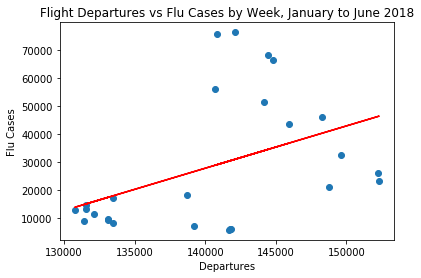

In [132]:
# Calculate the correlation coefficient and linear regression model 
# for flu vs air
%matplotlib inline
corr=round(st.pearsonr(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])[0],2)
print(f"The correlation between flight departures and flu cases is {corr}")
model = st.linregress(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])

y_values = flu_vs_air["Departures"]*model[0]+model[1]
plt.scatter(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])
plt.plot(flu_vs_air["Departures"],y_values,color="red")
plt.xlabel("Departures")
plt.ylabel("Flu Cases")
plt.title("Flight Departures vs Flu Cases by Week, January to June 2018")
plt.savefig("../images/flucorr.png")
plt.show()

In [145]:
### Correlation between departures & covid data ###
#display covid for us df:
#us_case

# Import and Load CSV
full_grouped_file = ("../project_data/covid_data/COVID-19-time-series-clean-complete.csv")
full_grouped_df = pd.read_csv(full_grouped_file)

#full_grouped_df

# remove the duplicated ID column
del full_grouped_df['Unnamed: 0']
#full_grouped_df

full_grouped_df = full_grouped_df[(full_grouped_df['Date'] > '2020-01-22') & (full_grouped_df['Date'] < '2020-06-31')]
#full_grouped_df

us_case = full_grouped_df[full_grouped_df["Country/Region"] == "US"]
us_case


,Date,Country/Region,Confirmed,Deaths,Recovered,Active
362,2020-01-23,US,1,0,0.0,1.0
550,2020-01-24,US,2,0,0.0,2.0
738,2020-01-25,US,2,0,0.0,2.0
926,2020-01-26,US,5,0,0.0,5.0
1114,2020-01-27,US,5,0,0.0,5.0
...,...,...,...,...,...,...
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0
29878,2020-06-28,US,2549864,126361,685164.0,1738339.0
30066,2020-06-29,US,2590668,126711,705203.0,1758754.0


In [146]:
#show dtypes for us_case
us_case.dtypes

Date               object
Country/Region     object
Confirmed           int64
Deaths              int64
Recovered         float64
Active            float64
dtype: object

In [148]:
#Change Date to datetime for us_case
us_case['Date'] = pd.to_datetime(us_case['Date'])
us_case

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Country/Region,Confirmed,Deaths,Recovered,Active
362,2020-01-23,US,1,0,0.0,1.0
550,2020-01-24,US,2,0,0.0,2.0
738,2020-01-25,US,2,0,0.0,2.0
926,2020-01-26,US,5,0,0.0,5.0
1114,2020-01-27,US,5,0,0.0,5.0
...,...,...,...,...,...,...
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0
29878,2020-06-28,US,2549864,126361,685164.0,1738339.0
30066,2020-06-29,US,2590668,126711,705203.0,1758754.0


In [149]:
#create covid by week column and display
us_case["Covid Week"] = us_case["Date"].dt.week
#us_case

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [150]:
#new df with mask for covid data 
wkstart = 4
wkend = 26
mask_covid = (us_case["Covid Week"] >= wkstart) & (us_case["Covid Week"] <= wkend)

covid_wk = pd.DataFrame()
covid_wk = us_case.loc[mask_covid]
#covid_wk

In [151]:
#redisplay air_wk
#air_wk

In [152]:
#build df with jan to june 2020 from combined_airport
start_2020 = '01-01-2020'
end_2020 = '06-30-2020'

#mask date column
mask_air = (combined_airport["Date"] >= start_2020) & (combined_airport["Date"] <= end_2020)

air2020_dates = pd.DataFrame()
air2020_dates = combined_airport.loc[mask_air]
#air2020_dates

In [153]:
#extract date and departures into new df, then pull covid data into this dataframe.
#air2020_dates

In [154]:
air2020_dates = combined_airport[["Date", "Airport", "Flight Type", "Departures"]]

#grouping by date
air2020_dates.groupby(["Date"])

air2020_dates["Air Week 2020"] = air2020_dates["Date"].dt.week
#air2020_dates

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
#new df with mask for airline data 2020
wkstart = 4
wkend = 26
mask_air20 = (air2020_dates["Air Week 2020"] >= wkstart) & (air2020_dates["Air Week 2020"] <= wkend)

air_wk20 = pd.DataFrame()
air_wk20 = air2020_dates.loc[mask_air20]
#air_wk20

In [156]:
#create new df with covid by week & departures by week
covid_final = covid_wk.groupby("Covid Week").sum()["Confirmed"]
air_final20 = air_wk20.groupby("Air Week 2020").sum()["Departures"]

# Create a DataFrame to hold results
covid_vs_air = pd.DataFrame({"Departures": air_final20, 
                           "Covid Cases": covid_final
                            })
#covid_vs_air

The correlation between flight departures and covid cases is -0.43


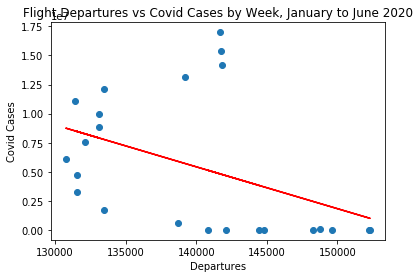

In [158]:
%matplotlib inline
# Calculate the correlation coefficient and linear regression model 
# for covid vs air

corr=round(st.pearsonr(covid_vs_air["Departures"],covid_vs_air["Covid Cases"])[0],2)
print(f"The correlation between flight departures and covid cases is {corr}")
model = st.linregress(covid_vs_air["Departures"],covid_vs_air["Covid Cases"])

y_values = covid_vs_air["Departures"]*model[0]+model[1]
plt.scatter(covid_vs_air["Departures"],covid_vs_air["Covid Cases"])
plt.plot(covid_vs_air["Departures"],y_values,color="red")
plt.xlabel("Departures")
plt.ylabel("Covid Cases")
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels([0,1,2,3])
plt.title("Flight Departures vs Covid Cases by Week, January to June 2020")
plt.savefig("../images/covidcorr.png")
plt.show()